# Исследование рынка общественных заведений в Москве

# Описание и импорт данных

## Описание проекта

Компания хочет открыть небольшое кафе в Москве. Ключевая идея – вместо официантов роботы. Проект дорогой, поэтому нужно привлекать инвестиции. Инвесторы для оценки идеи запросили текущее положение дел на рынке.

**Цель исследования**: Изучить текущее состояние рынка в разрезе характеристик и местоположения заведений. На основе этих данных предоставить инвесторам доказательства потенциального успеха бизнеса.

**Общий план исследования**:
1. Предобработаем данные.
2. Исследуем характеристики заведений: принадлежность к сети, количество посадочных мест, тип заведения.
3. Исследуем местоположения заведений.
4. Сделаем общие выводы и дадим рекомендации.
5. Подготовим данные для инвесторов.

## Описание данных

У нас есть данные о заведениях общественного питания в Москве.

Таблица **`rest_data`**:
* `id` — идентификатор объекта;
* `object_name` — название объекта общественного питания;
* `chain` — сетевой ресторан;
* `object_type` — тип объекта общественного питания;
* `address` — адрес;
* `number` — количество посадочных мест.

## Импорт библиотек

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib as mpl
import plotly.express as px
import re
import plotly.io as pio
import warnings

from geopandas.tools import geocode
warnings.filterwarnings('ignore')
pio.renderers.default='jpeg'

In [2]:
# настроим некоторые параметры отображения графиков
custom_params = {
    'figure.figsize': (14,6),
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.titlesize': 16,
    'axes.titleweight': 'bold',
    'axes.grid': True,
    'axes.grid.axis': 'y',
    'grid.alpha': 0.5,
    'axes.formatter.limits': [-10, 10], # условия для отображения научного формата
}

for key, val in custom_params.items():
    mpl.rcParams[key] = val

# цвета для графиков
colors = ['#303F9F', '#F57C00','#388E3C','#C2185B','#FBC02D','#5D4037',
          '#455A64', '#D32F2F', '#1976D2', '#AFB42B', '#689F38','#512DA8','#00796B','#689F38']

## Импорт данных

Импортируем данные, посмотрим первые значения и общую информацию по датасету:

In [3]:
# импорт данных
try:
    data = pd.read_csv('datasets/rest_data.csv') # для работы на jupyterhub
except:
    data = pd.read_csv('/datasets/rest_data.csv') # для локальной работы

In [4]:
# выведем первые 5 строк
data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [5]:
# основная информация по данным
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Из первого взгляда на данные видно, что в них нет пропусков и все данные правильного типа.

# Предобработка данных

В целом данные у нас неплохие. Мы уже увидели, что у нас нет пропусков, что все типы данных корректные. Нам осталось проверить данные на явные и неявные дубликаты. Также добавим столбец с улицами, на которых располагаются заведения и заменим названия типов заведений на более короткие. Это пригодится нам в дальнейшем исследовании.

## Изменение названий типов заведений

В данных есть названия заведений которые можно сократить:
* "предприятие быстрого обслуживания" на "фастфуд",
* "магазин (отдел кулинарии)" на "кулинария"

С короткими названиями проще воспринимать информацию и на графиках они будут смотреться аккуратнее.

In [6]:
# сокращаем названия типов заведений
data['object_type'] = data['object_type'].replace({
    'предприятие быстрого обслуживания': 'фастфуд',
    'магазин (отдел кулинарии)': 'кулинария'
})

## Проверка на наличие дубликатов

Сначала проверим данные на явные дубликаты:

In [7]:
print('Количество явных дубликатов:', data.duplicated().sum())

Количество явных дубликатов: 0


Теперь попробуем проверить на дубликаты все столбцы за исключением `id`:

In [8]:
print(
    'Количество явных дубликатов, без учета столбца id:',
    data.duplicated(subset=['object_name', 'chain', 'object_type', 'address', 'number']).sum()
)

Количество явных дубликатов, без учета столбца id: 82


In [9]:
# срезаем дубликаты
data = data[~data.duplicated(subset=['object_name', 'chain', 'object_type', 'address', 'number'])]

Отлично, явные дубликаты мы убрали.

Проверим данные на наличие неявных дубликатов:

In [10]:
# проверка уникальности id
len(data) - data['id'].nunique()

0

In [11]:
# выведем уникальные значения в параметре с указаением сетевое заведение или нет 
print(data['chain'].unique())

['нет' 'да']


In [12]:
# выведем уникальные значения в типе заведения
print(data['object_type'].unique())

['кафе' 'столовая' 'закусочная' 'фастфуд' 'ресторан' 'кафетерий' 'буфет'
 'бар' 'кулинария']


В столбцах id, chain, object_type неявных дубликатов нет. С названиями заведений все немного сложнее. В названиях много неявных дубликатов, например вот дубликаты заведения Макдоналдс:

In [13]:
# неявные дубликаты по заведению "макдоналдс"
data[data['object_name'].str.contains('макдоналдс', case=False)]['object_name'].unique()

array(['МАКДОНАЛДС', 'Ресторан «Макдоналдс»', 'Макдоналдс',
       'Предприятие быстрого обслуживания «Макдоналдс»',
       'МОСКВА - МАКДОНАЛДС', 'КАФЕ МАКДОНАЛДС', 'КАФЕ «МАКДОНАЛДС»',
       'Кафе «МАКДОНАЛДС»', 'РЕСТОРАН«МАКДОНАЛДС»', 'Кафе «Макдоналдс»'],
      dtype=object)

Столько Макдональдсов, аж стало больно... ой, кхм.

Все это явно тот самый единственный и неповторимый Макдоналдс. Вот список признаков дубликатов:
* В названии присутствует тип заведения,
* Разные регистры,
* Кавычки.

Создадим функцию, которая очистит названия от этих признаков:

In [14]:
# список с типами заведений
object_types = data['object_type'].unique()

# функция для очистки имен
def clean_names(name):
    
    # вернем название в нижнем регистре, если название состоит из 1 слова
    if len(name.split()) == 1:
        return name.lower()
    
    # переводим в нижний регистр
    result = name.lower()
    
    # убираем из названия тип объекта
    for obj_type in object_types:
        if re.match(obj_type, result):
            result = re.sub(obj_type, '', result)
            
    # убираем кавычки из названия
    result = re.sub('[«»]', '', result)
    
    # убираем пробелы по краям
    result = result.strip()

    return result

In [15]:
# применим функцию к названиям и посмотрим сколько значений мы очистили
print('Количество уникальных названий заведений до очистки неявных дубликатов: {}'.format(data['object_name'].nunique()))

data['object_name'] = data['object_name'].apply(clean_names)

print('Количество уникальных названий заведений после очистки от неявных дубликатов: {}'
      .format(data['object_name'].nunique()))

Количество уникальных названий заведений до очистки неявных дубликатов: 10393
Количество уникальных названий заведений после очистки от неявных дубликатов: 9365


После применения функции мы убрали более 1000 дубликатов названий. Посмотрим как теперь выглядит список названий со словом "макдоналдс":

In [16]:
# неявные дубликаты по заведению "макдоналдс"
data[data['object_name'].str.contains('макдоналдс', case=False)]['object_name'].unique()

array(['макдоналдс', 'предприятие быстрого обслуживания макдоналдс',
       'москва - макдоналдс', 'ресторан«макдоналдс»'], dtype=object)

Отлично, вместо 11 осталось всего 3 (все как в жизни 🥲). Этого достаточно для более точного анализа.

<div class="alert alert-block alert-info">
<font size='4'><b>Комментарий студента</b></font>    
    
Ого, спасибо за комментарий, на будущее буду держать это в голове!
    
</div>

## Добавление столбца с улицами

Добавим улицы на которых расположены заведения в отдельный столбец датафрейма. Это пригодится нам для дальнейшего исследования.

In [17]:
# словарь с типами улиц
types = ['улица', 'шоссе', 'проспект', 'бульвар', 'проезд',
                'переулок', 'набережная', 'площадь', 'аллея', 'квартал',
               'микрорайон', 'территория']

def get_street(address):
    # разделяем строку адреса
    address_splited = address.split(',')
    
    # проверим каждый элемент адреса на принадлежность к типу улиц
    for elem in address_splited:
        for street_type in types:
            if street_type in elem.lower():
                return elem.strip()

In [18]:
# применим функцию
data['street'] = data['address'].apply(get_street)

In [19]:
# выведем первые 5 значений 
data.head()

,id,object_name,chain,object_type,address,number,street
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,академия,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,вишневая метель,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица


Улицы на месте, и выглядят правдоподобно.

## Выводы

В данных мы не нашли явных дубликатов, зато неявных дубликатов в столбце с названиями заведений навалом. Мы как могли почистили их: перевели в нижний регистр, убрали из названий типы заведений, убрали кавычки. Всего после чистки стало на 1000 неявных дубликатов меньше.

Также в исходный датафрейм мы добавили столбец с названием улицы, на которой располагается заведение.

Данные готовы к анализу.

# Исследование заведений по типам

Начнем исследование данных с изучения видов заведений. 

Цель данного этапа ответить на вопросы:
* Какие виды заведений самые популярные?
* Для какого вида заведений характерно сетевое распространение?
* Какое количество мест характерно для каждого вида заведения?
* Какое количество посадочных мест характерно для сетевых заведений?

Последовательно ответим на все эти вопросы. А главным инструментом для поиска ответов будут графики.

Создадим функцию для стилизации графиков:

In [20]:
# функция для настройки стиля в графиках
def style_plot(
    xlabel,
    ylabel,
#     text_tmpl='%{y:.0f}',
#     yticks=False
    
):
    fig.update_layout(
        autosize=True,
        xaxis_title_text=xlabel,
        yaxis_title_text=ylabel,
        plot_bgcolor='white',
        xaxis=dict(
            showline=True,
            linecolor='#58595B',
            color='black',
            categoryorder='total descending'
        ),
        yaxis=dict(
            color='black',
            showgrid=True,
            gridcolor='#E6E7E8',
#             showticklabels=yticks
        ),
        title=dict(
            font=dict(
                color='black'
            )
        )
    )
#     fig.update_traces(texttemplate=text_tmpl ,textposition='outside')

### Какие виды заведений самые популярные?

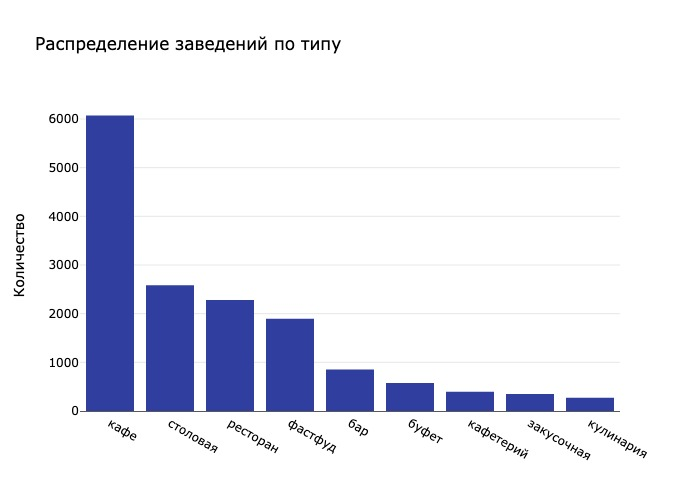

In [21]:
# гистограмма распределения заведений по типу
fig = px.histogram(
    data.replace({'предприятие быстрого обслуживания': 'фастфуд'}),
    x='object_type',
#     text_auto=True,
    title='Распределение заведений по типу',
    color_discrete_sequence=colors,
    labels={'object_type': 'Тип заведения'},
)

# выводим стилизованную гистограмму
style_plot(xlabel='', ylabel='Количество')
fig.update_traces(hovertemplate="Тип заведения: %{x}<br>Количество заведений: %{y:.0f}")
fig.show()

<div class="alert alert-block alert-info">
<font size='4'><b>Комментарий студента</b></font>    
    
Урезал некоторую красоту, ради работоспособности... Поэтому тебе придется на слово поверить, что графики выглядели просто великолепно...
    
😝
    
</div>

Судя по графику самый популярный тип заведения – кафе. В Москве открыто более 6000 заведений этого типа. Следом идет группа: столовые, рестораны и фастфуд. В этих категориях открыто от 2000 до 2500 заведений. У остальных типов открыто не более 900 заведений.

### Для какого вида заведения характерно сетевое распространение?

Для начала посмотрим на общую картину по сетевым заведениям:

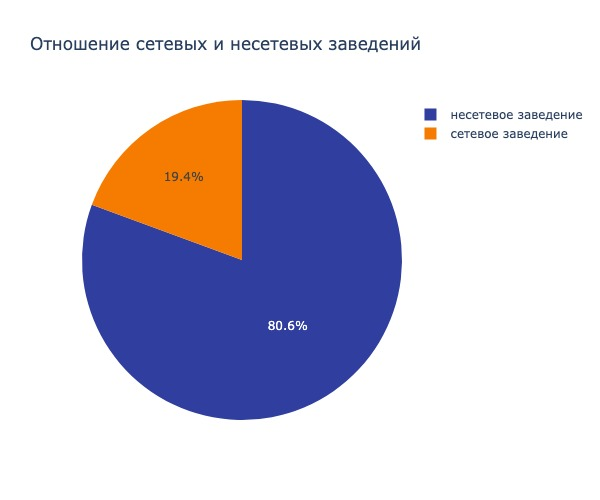

In [22]:
# готовим данные для визуализации
to_plot = data['chain'].value_counts().reset_index().replace({'да': 'сетевое заведение', 'нет': 'несетевое заведение'})

# строим фигуру
fig = px.pie(
    to_plot,
    values='chain',
    names='index',
    title='Отношение сетевых и несетевых заведений',
    labels={'index': 'Вид заведения', 'chain': 'Количество'},
    color_discrete_sequence=colors,
    width=600
    
)

# отобразим легенду
fig.update_traces(
    showlegend=True, 
)

fig.show()

Лишь каждое 5 заведение принадлежит какой-либо сети.

Посмотрим на доли сетевых заведений среди всех типов заведений:

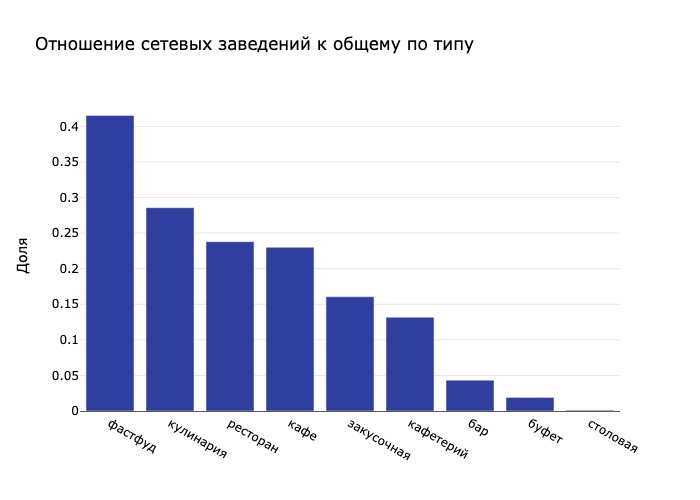

In [23]:
# готовим данные для построения графика
to_plot = data.pivot_table(
    index='object_type',
    columns='chain',
    values='id',
    aggfunc='count'
)
to_plot['chain_share'] = to_plot['да'] / (to_plot['да'] + to_plot['нет'])

# строим фигуру
fig = px.bar(
    to_plot,
    x=to_plot.index,
    y=to_plot['chain_share'],
    color_discrete_sequence=colors,
#     text_auto=True,
    title='Отношение сетевых заведений к общему по типу',
    
)

# стилизуем фигуру
style_plot(xlabel='', ylabel='Доля')
fig.update_traces(hovertemplate="Тип заведения: %{x}<br>Доля сетевых заведений: %{y:.0%}")
fig.show()

* Больше всего сетевых заведений характерно для фастфуда. В этой категории почти 41% от всех заведений входят в ту или иную сеть.
* Затем следует с показателем 29% кулинария.
* Рестораны и кафе имеют примерно одинаковый показатель: 24% и 23% соответственно.
* Самые же несетевые категории это – бар, буфет, столовая. Их показатели 4%, 2% и менее 1% соответственно.

### Какое количество посадочных мест характерно для каждого вида заведения?

Вывод о характерном количестве мест будем делать по средним показателям для каждого вида заведения. Осталось определить: использовать медиану или среднее арифметическое. Для этого построим сводную таблицу:

In [24]:
# создадим сводную таблицу 
to_plot = data.pivot_table(
    index='object_type',
    values='number',
    aggfunc=['median', 'mean', 'max']
)

to_plot

,median,mean,max
,number,number,number
object_type,,,
бар,35,43.533333,1700
буфет,32,51.509532,320
закусочная,0,7.825215,216
кафе,30,39.785703,533
кафетерий,6,9.184810,200
кулинария,0,5.589744,50
ресторан,80,96.884750,1500
столовая,103,130.337848,1400


Во всех видах заведений присутствуют выбросы с максимальным значением. Поэтому будем использовать медиану, которая более устойчива к выбросам.

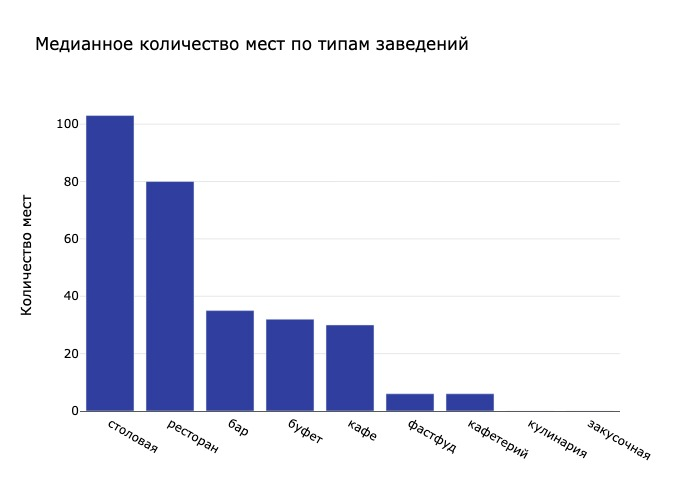

In [25]:
# строим фигуру
fig = px.bar(
    x=to_plot.index,
    y=to_plot['median']['number'],
    color_discrete_sequence=colors,
    title='Медианное количество мест по типам заведений'
)

# выводим стилизованный график
style_plot(xlabel='', ylabel='Количество мест')
fig.update_traces(hovertemplate='Тип заведения: %{x}<br>Количество мест: %{y}')
fig.show()

По графику заметны 3 группы заведений:
1. Заведения с большой вместимостью (от 80 мест до 105 мест): столовые, рестораны;
2. Заведения со средней вместимостью (от 30 до 35 мест): бары, буфеты, кафе;
3. Заведения с малой вместимостью (до 6 мест): кафетерии, фастфуды, кулинарии, закусочные.

Но при этом нужно помнить, что это лишь средние значения, которые дают общее понимание. При детальном рассмотрении можно увидеть много неожиданного. Например, самое большое количество мест среди всех заведений не у столовой или ресторана, а у бара (1700 мест).

### Какое количество посадочных мест характерно для сетевых заведений?

Сузим выборку. Оставим только сетевые заведения, и посмотрим на среднее количество мест по ним.

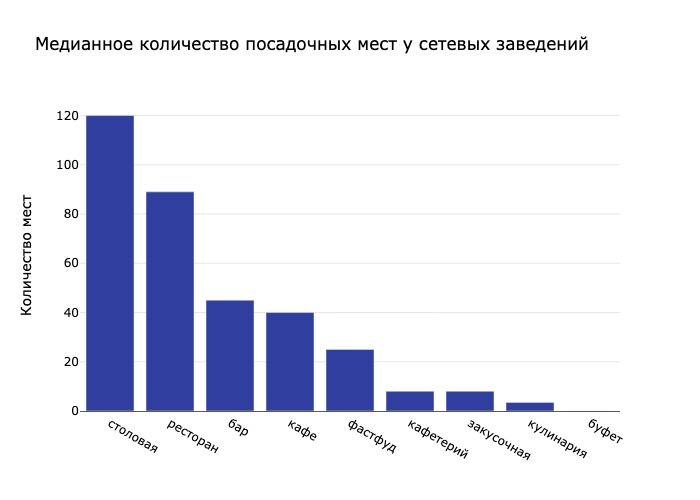

In [26]:
# готовим данные для графика
to_plot = data.query('chain == "да"').pivot_table(
    index='object_type',
    values='number',
    aggfunc=['median', 'mean', 'max']
)


fig = px.bar(
    x=to_plot.index,
    y=to_plot['median']['number'],
    color_discrete_sequence=colors,
    title='Медианное количество посадочных мест у сетевых заведений'
)


style_plot(xlabel='', ylabel='Количество мест')
fig.update_traces(hovertemplate='Тип заведения: %{x}<br>Среднее значение: %{y}')
fig.show()

Критически ситуация не поменялась. Из интересных моментов заметно лишь:
* Для большинства сетевых заведений характерно увеличение посадочных мест.
* У сетевых заведений с фастфудом в 5 раз больше мест, чем в среднем с учетом несетевых заведений.
* Медианных показатель количества мест для сетевых буфетов равен 0, хотя при общем рассмотрении он был 32. Но все дело в том, что сетевых буфетов крайне мало. Поэтому какие-то выводы делать некорректно.

Теперь попробуем узнать есть ли зависимость среднего количества мест в заведения от размера сети. Для этого создадим сводную таблицу с размерами сети и медианным значением количества мест. Затем построим scatterplot и попробуем визуально определить зависимость:

In [27]:
# создадим сводную таблицу
chain_data = (
    data.query('chain == "да"')
    .pivot_table(
        index=['object_type', 'object_name'],
        aggfunc={'id': 'count', 'number': 'median'},
    )
    .reset_index()
    .rename(columns={'id': 'size_of_chain', 'number': 'median_seats'})
    # чтобы убрать шумы возьмем только сети, в которых более 5 заведений 
    .query('size_of_chain >= 5')
)

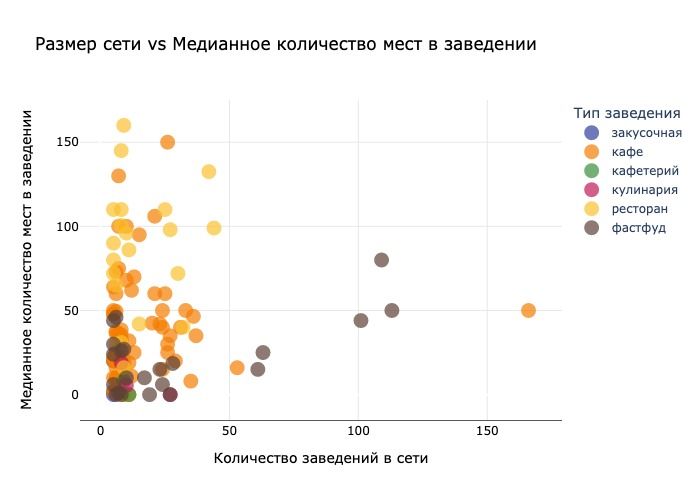

In [28]:
# строим график
fig = px.scatter(
    x=chain_data['size_of_chain'],
    y=chain_data['median_seats'],
    color=chain_data['object_type'],
    color_discrete_sequence=colors,
    labels={
        'x': 'Количество заведений в сети',
        'y': 'Медианное количество мест в заведении',
        'color': 'Тип заведения'
    },
    title='Размер сети vs Медианное количество мест в заведении',
)

# наводим красоту
fig.update_traces(
    marker=dict(
        size=15,
        opacity=0.7
    )
)
fig.update_layout(
    xaxis=dict(
        showgrid=True,
        gridcolor='#E6E7E8',
    )
)
style_plot(xlabel='Количество заведений в сети', ylabel='Медианное количество мест в заведении')

fig.show()

In [29]:
# посмотрим корреляцию
print('Корреляция между размером сети и количеством мест в заведении:', 
      chain_data['size_of_chain'].corr(chain_data['median_seats']))

Корреляция между размером сети и количеством мест в заведении: 0.07938093277509028


По графику видно:
* Размер большинства сетей до 15 заведений. Количество мест в этих заведениях варьируется от 0 до 50.
* Среди сетей с небольшим количеством заведений, но большим количеством мест видны некоторые сети ресторанов и кафе.
* Также есть несколько сетей фастфуда и одна сеть кафе в которых более 100 заведений, в которых 40-80 мест.
* Корреляция между количеством заведений и количеством мест совсем небольшая.

## Выводы

Мы изучили характеристики разных типов заведений. Вот некоторые выводы, которые мы смогли сделать:
* Кафе – самый популярный тип заведения в Москве. Всего в городе открыто более 6000 кафе, что более чем в 2 раза превышает второй по популярности тип заведений.
* 41% заведений типа фастфуд входят в сети. Самые уникальные заведения в типах: бар, буфет, столовая. Почти каждое четвертое кафе сетевое.
* По количество посадочных мест заведения можно разбить на 3 группы:
    1. Заведения с большой вместимостью (от 80 мест до 105 мест): столовые, рестораны;
    2. Заведения со средней вместимостью (от 30 до 35 мест): бары, буфеты, кафе;
    3. Заведения с малой вместимостью (до 6 мест): кафетерии, фастфуды, кулинарии, закусочные.
* В сетевых заведениях в среднем больше мест, чем в несетевых. Лишь для буфетов это правило работает наоборот.

# Исследование заведений по местоположению

Изучим заведения по их местоположению. Наша цель найти районы с самой высокой конкуренцией и районы, которые пока не сильно развиты в плане количества заведений. Благодаря полученным знаниям, мы сможем выбрать местоположение для нашего заведения.

Для того, чтобы определить район по улице, возьмем еще один датасет. В нем будут храниться улицы и районы, которым принадлежат эти улицы. 

In [30]:
import requests
from urllib.parse import urlencode

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/ZN6BqCjNt14CbQ'

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# Загружаем файл и сохраняем его
download_response = requests.get(download_url)
with open('streets_by_districts.csv', 'wb') as f:
    f.write(download_response.content)

In [31]:
# прочитаем датасет с районами Москвы
msk_districts = pd.read_csv('streets_by_districts.csv', index_col=0)

In [32]:
# выведем первые 5 строк датасета
msk_districts.head()

,street,district
0,1-й Ирининский переулок,Басманный район
1,2-й Ирининский переулок,Басманный район
2,3-й Ирининский переулок,Басманный район
3,Иркутская улица,район Гольяново
4,1-й Иртышский проезд,район Гольяново


## Топ-10 улиц по количеству заведений

Выведем график топ-10 улиц с самым большим количеством заведений:

In [33]:
# срез улиц с наибольшим количеством заведений
popular_streets = (
    data.groupby('street')['id']
    .count()
    .sort_values(ascending=False)
    .reset_index()
    
)

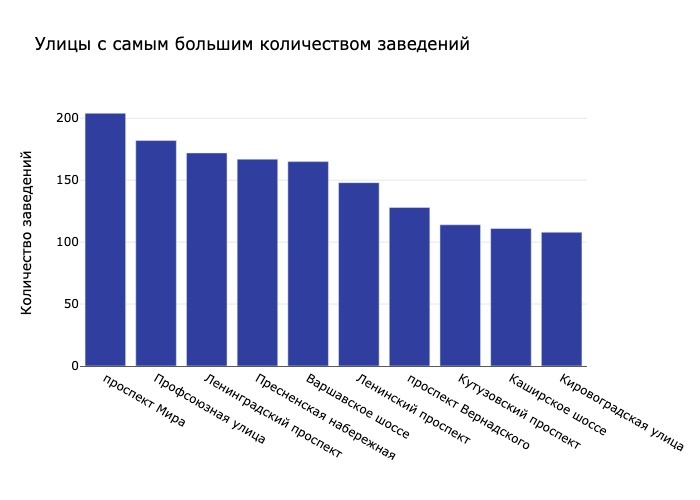

In [34]:
# создаем фигуру
fig = px.bar(
    x=popular_streets['street'].iloc[:10],
    y=popular_streets['id'].iloc[:10],
    color_discrete_sequence=colors,
    title='Улицы с самым большим количеством заведений'
)

# наводим красоту
style_plot(xlabel='', ylabel='Количество заведений')
fig.update_traces(hovertemplate='Количество: %{y}')
fig.show()

Теперь посмотрим в каких районах располагаются эти улицы:

In [35]:
# добавим районы
popular_districts = popular_streets.iloc[:10].merge(msk_districts, on='street', how='left')

Посмотрим на расположение этих улиц на карте Москвы. Для этого напишем функцию, которая будет находить координаты местоположения. Затем используем график scatter_mapbox для отображения этих координат на карте.

In [36]:
popular_streets.iloc[:10]

,street,id
0,проспект Мира,204
1,Профсоюзная улица,182
2,Ленинградский проспект,172
3,Пресненская набережная,167
4,Варшавское шоссе,165
5,Ленинский проспект,148
6,проспект Вернадского,128
7,Кутузовский проспект,114
8,Каширское шоссе,111
9,Кировоградская улица,108


In [37]:
popular_streets.iloc[:10].merge(msk_districts, on='street', how='left')

,street,id,district
0,проспект Мира,204,Мещанский район
1,Профсоюзная улица,182,Академический район
2,Ленинградский проспект,172,район Аэропорт
3,Пресненская набережная,167,Пресненский район
4,Варшавское шоссе,165,Донской район
5,Ленинский проспект,148,район Якиманка
6,проспект Вернадского,128,Гагаринский район
7,Кутузовский проспект,114,район Дорогомилово
8,Каширское шоссе,111,район Москворечье-Сабурово
9,Кировоградская улица,108,район Чертаново Северное


In [38]:
# функция для определения координат
def get_location(district):
    loc = geocode('Москва, ' + district, provider="nominatim" , user_agent = 'my_request').geometry
    return loc

In [39]:
# создадим датафрейм с районами в которые входят топ-10 самых популярных улиц
popular_districts = pd.DataFrame({
    'district': popular_districts['district'],
    'objects': popular_districts['id']
})

# добавим локацию
popular_districts['loc'] = popular_districts['district'].apply(get_location)

# добавим долготу
popular_districts['lat'] = popular_districts['loc'].apply(lambda l: l.y)

# длбавим широту
popular_districts['lon'] = popular_districts['loc'].apply(lambda l: l.x)

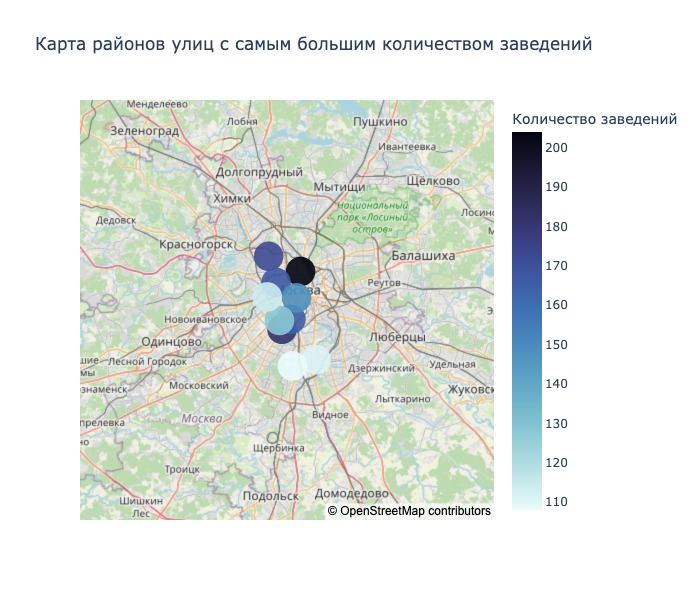

In [40]:
# строим карту распределения заведений
fig = px.scatter_mapbox(
    popular_districts,
    lat="lat",
    lon="lon",
    zoom=8,
    color='objects',
    title='Карта районов улиц с самым большим количеством заведений',
    color_continuous_scale='ice_r',
    hover_name='district',
    height=600,
    labels={'objects': 'Количество заведений'}
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_traces(
    marker=dict(
        size=30,
        opacity=0.9,
    ),
)

fig.show()

На карте видно, что самые популярные улицы располагаются в центральных и южных районах Москвы в пределах МКАД. При этом на севере и востоке таких улиц нет.

## Топ-10 районов по количеству улиц с одним заведением

Теперь посмотрим на улицы, которые напротив не пользуются популярностью и имеют всего одно заведение:

In [41]:
# срез улиц с одним заведением
unpopular_streets = (
    data.groupby('street')['id']
    .count()
    .reset_index()
    .query('id == 1')
)

Улицы готовы, но нас интересуют районы. Добавим районы и уберем улицы:

In [42]:
# добавим к улицам районы
unpopular_ditricts = unpopular_streets.merge(msk_districts, on='street', how='left').dropna(axis=0)

# посчитаем количество улиц с одним заведением по районам
unpopular_ditricts = unpopular_ditricts['district'].value_counts().iloc[:10]

Строим гистограмму:

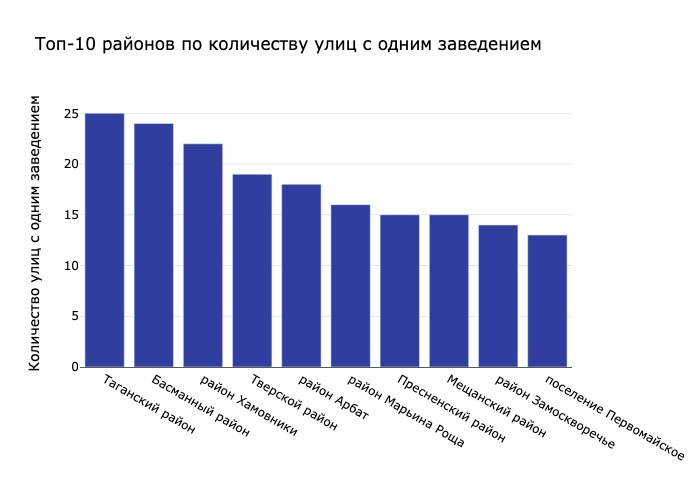

In [43]:
# строим фигуру
fig = px.bar(
    x=unpopular_ditricts.index,
    y=unpopular_ditricts.values,
    color_discrete_sequence=colors,
    title='Топ-10 районов по количеству улиц с одним заведением'
)

style_plot(xlabel='', ylabel='Количество улиц с одним заведением')

fig.show()

Посмотрим где находятся эти районы на карте:

In [44]:
# создадим датафрейм с топ-10 районов по количеству улиц с одним заведением
unpopular_ditricts = pd.DataFrame({
    'district': unpopular_ditricts.index,
    'objects': unpopular_ditricts.values
})

# добавим локацию
unpopular_ditricts['loc'] = unpopular_ditricts['district'].apply(get_location)

# добавим долготу
unpopular_ditricts['lat'] = unpopular_ditricts['loc'].apply(lambda l: l.y)

# длбавим широту
unpopular_ditricts['lon'] = unpopular_ditricts['loc'].apply(lambda l: l.x)

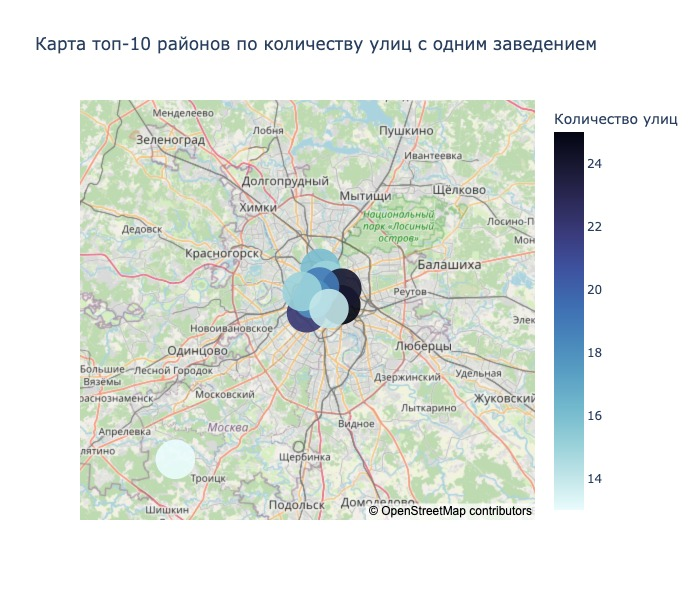

In [45]:
# строим карту расположения районов
fig = px.scatter_mapbox(
    unpopular_ditricts,
    lat="lat",
    lon="lon",
    zoom=8,
    color='objects',
    title='Карта топ-10 районов по количеству улиц с одним заведением',
    color_continuous_scale='ice_r',
    hover_name='district',
    height=600,
    labels={'objects': 'Количество улиц'}
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_traces(
    marker=dict(
        size=40,
        opacity=0.9,
    ),
)

fig.show()

Хмм... Все районы располагаются в центре. Но как будто бы это неочевидный ответ. Возможно результат исказило то, что в центре множество маленьких улочек, переулков и бульваров, на которых с бОльшей вероятностью будет мало заведений. Но все же зафиксируем текущий результат и посмотрим, что будет если оставить только улицы:

Чтобы получить более корректные результаты, оставим именно улицы, без учета переулков, бульваров и так далее. Сделаем мы это потому, что в центре города очень много небольших переулков, на которых с большей вероятностью будет одно заведение.

In [46]:
# оставим только улицы
unpopular_streets = unpopular_streets[unpopular_streets['street'].str.contains('улица')]

In [47]:
print('Количество улиц на которых всего 1 заведение:', len(unpopular_streets))

Количество улиц на которых всего 1 заведение: 257


В Москве есть целых 257 улиц на которых есть только одно заведение. Попробуем определить районы в которых располагаются эти улицы.

Добавим в срез с самыми непопулярными улицами районы. Затем оставим топ-10 таких районов:

In [48]:
# добавим к улицам их районы
unpopular_ditricts = unpopular_streets.merge(msk_districts, on='street', how='left').dropna(axis=0)

unpopular_ditricts = unpopular_ditricts['district'].value_counts().iloc[:10]

Построим график и узнаем какие районы вошли в наш список:

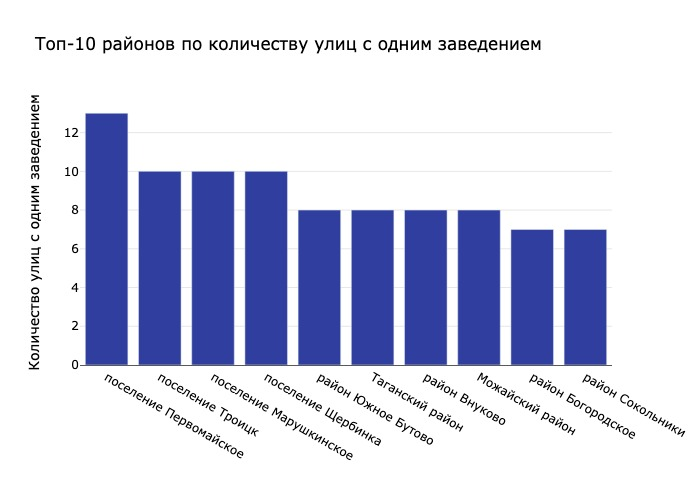

In [49]:
# строим фигуру
fig = px.bar(
    x=unpopular_ditricts.index,
    y=unpopular_ditricts.values,
    color_discrete_sequence=colors,
    title='Топ-10 районов по количеству улиц с одним заведением'
)

style_plot(xlabel='', ylabel='Количество улиц с одним заведением')

fig.show()

Теперь отметим эти районы на карте и сделаем выводы по их местоположению:

In [50]:
# создадим датафрейм с топ-10 районов по количеству улиц с одним заведением
unpopular_ditricts = pd.DataFrame({
    'district': unpopular_ditricts.index,
    'objects': unpopular_ditricts.values
})

# добавим локацию
unpopular_ditricts['loc'] = unpopular_ditricts['district'].apply(get_location)

# добавим долготу
unpopular_ditricts['lat'] = unpopular_ditricts['loc'].apply(lambda l: l.y)

# длбавим широту
unpopular_ditricts['lon'] = unpopular_ditricts['loc'].apply(lambda l: l.x)

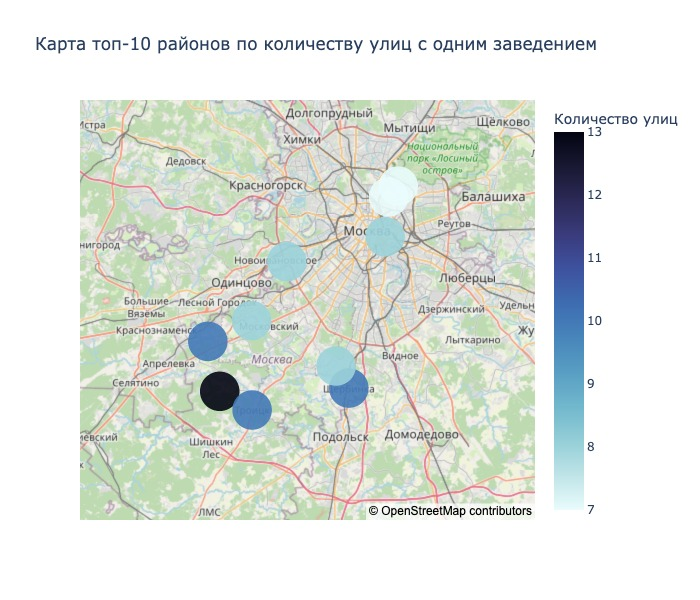

In [51]:
# строим карту расположения районов
fig = px.scatter_mapbox(
    unpopular_ditricts,
    lat="lat",
    lon="lon",
    zoom=8,
    color='objects',
    title='Карта топ-10 районов по количеству улиц с одним заведением',
    color_continuous_scale='ice_r',
    hover_name='district',
    height=600,
    labels={'objects': 'Количество улиц'}
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_traces(
    marker=dict(
        size=40,
        opacity=0.9,
    ),
)

fig.show()

Теперь результат больше похож на правду. Большинство районов находятся в новой Москве, то есть на юго-западной окраине. Два района находятся на северо-востоке и один близко к центру. В принципе тенденция очевидна – на улицах окраин мало заведений общепита.

## Выводы

Мы посмотрели в каких районах находятся улицы, где больше всего заведений и в каких районах находится больше всего улиц с одним заведением. При анализе улиц с одним заведением, мы оставили именно улицы, так как на проездах, переулках и пр., вероятность встретить лишь 1 заведение заведомо выше.

Самая большая конкуренция в центральных районах. Там встречаются улицы на которых более 100 заведений. Самая плотная на заведения улица в Москве – проспект Мира. Там находится целых 204 заведения.

Самые "пустые" районы находятся в новой Москве. Там находится 7 районов в которых как минимум 8 улиц на которых сейчас открыто лишь 1 заведение. Также видна тенденция – чем дальше район, тем больше на нем будет улиц с малым количеством заведений.

# Общие выводы и рекомендации

## Выводы

Мы завершили исследование рынка заведений общепита Москвы. Мы изучили виды заведений, сетевое распространение заведений, количество мест и местоположение. 

Сделаем краткие выводы по каждой из характеристик.

**Виды заведений**

Самый популярный вид заведения – кафе. В Москве открыто 6099 заведений данного типа. После кафе идет группа из: столовых, ресторанов и предприятий быстрого обслуживания. Количество заведений у видов из этой группы от 1900 до 2600. Среди остальных видов лидируют бары. Их в Москве около 900. Остальных же видов не более 600.

**Сетевое распространение**

Сетевое распространение наиболее характерно у предприятий быстрого обслуживания. 41% заведений этого вида входит в какую-либо сеть. Также в сети входят четверть ресторанов и кафе и почти 30% отделов кулинарий в магазинах.

Наиболее оригинальные виды заведений: бары, буфеты и столовые. Лишь 4%, 2% и менее 1% этих заведений входят в сети соответственно.

**Количество мест**

Больше всего посадочных мест у столовых и ресторанов. В среднем у них 103 и 80 мест соответственно. После них идут: бары, буфеты и кафе. В них в среднем 30-35 посадочных мест. Почти без посадочных мест в среднем работают: предприятия быстрого обслуживания, кафетерии, кулинарии и закусочные.

Если брать срез сетевых заведений, то заметно ситуация поменяется у предприятий быстрого обслуживания и буфетов. У сетевых предприятий быстрого обслуживания в среднем в 5 раз больше посадочных мест, чем у несетевых. А сетевых буфетов слишком мало, поэтому их результат 0 мест сложно интерпретировать.

**Местоположение**

Самая высокая конкуренция наблюдается в центре и на юге Москвы. Там встречаются улицы, на которых более 100 заведений. Самая плотная с точки зрения заведений улица – проспект Мира, там 204 заведения.  

На окраинах, наоборот, множество улиц имеют всего лишь 1 заведение. Большинство таких районов находятся в новой Москве. Также заметен тренд – чем дальше район, тем больше на нем будет улиц с одним заведением.

## Рекомендации



Напомним вводные характеристики нашего заведения:
* оригинальная фишка – обслуживать гостей будут роботы,
* проект дорогой,
* заведение небольшое.

Самым подходящим видом заведения исходя из наших характеристик будет – бар. Баров в Москве относительно немного. Как правило они средних размеров, на 35-45 мест. Да и работать с напитками роботам возможно будет проще, чем с блюдами. Все эти плюсы помогут немного снизить стоимость и без того дорогого проекта.

Так как наша идея, что гостей будут обслуживать роботы, следовательно при сетевом распространении мы сможем задать один стандарт качества обслуживания. А это очень важный критерий для сети. На данный момент сети баров не слишком распространены. Это одновременно и плюс и минус. Плюс в том, что это голубой океан и если проект будет успешным, у нас будет меньше конкуренции. Минус же в том, что отсутствие сетей может быть показателем, что у людей нет запроса на сетевые бары. То есть в данном случае мы идем на дополнительный риск.

Проект изначально дорогой, соответственно это будет влиять и на цены. Также проект с высокой степенью неопределенности, поэтому нужно много гостей для тестирования идеи. То есть у нас есть 2 критерия для выбора местоположения – достаток гостей и их количество. Очевидно, что чем ближе к центру, тем больше вероятность удовлетворить эти критерии. Но тут встает следующий аспект – дороговизна. Поэтому для первого заведния мы бы рекомендовали выбрать район на не такой близкий к центру, но и не попадающий в "пустые" районы. Как вариант можно рассмотреть Северное Чертаново.